# Week4

## 1. Load and imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import spacy
import nltk
import octis
from tqdm import tqdm_notebook
from tqdm import tqdm

tqdm.pandas()
tqdm_notebook().pandas()

/var/folders/n1/2dp16v113lv8x5rwt1t69_v40000gn/T/ipykernel_37531/2568179296.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_notebook().pandas()


In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
df_cond = pd.read_csv('./../../Data/Dataframes/df_condorcet_processed.csv')

## 2. Pre-Processing

### a. Removing Side info

In [4]:
df_cond['Side_Info'] = df_cond['Eloge'].apply(lambda x : re.findall('\[(.*?)\]', x))

In [5]:
df_cond['Eloge'] = df_cond['Eloge'].apply(lambda x : re.sub('\[(.*?)\]','', x))

### b. Removing \n, \t, non useful spaces

In [6]:
df_cond['Eloge'] = df_cond['Eloge'].apply(lambda x : x.replace("\\n", "").replace("\\t", "").replace("\n", "").replace("\t", "")
                               .strip())

### c. Removing punctuations

In [7]:
df_cond['Eloge_no_punkt'] = df_cond['Eloge'].apply(lambda x : re.sub(r'[^\w\s]', ' ', x))


### d. Removing stop-words and words smaller than 2

In [8]:
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from nltk.corpus import stopwords

stop_words =set(stopwords.words('french'))

print('Number of stop-words in spacy : ' + str(len(fr_stop)))
print('Number of stop-words in nltk : ' + str(len(stop_words)))


Number of stop-words in spacy : 507
Number of stop-words in nltk : 157


In [9]:
df_cond['Eloge_no_sw_no_punkt'] = df_cond['Eloge_no_punkt'].apply(lambda x : " ".join([i for i in x.split() if 
                                                                             (i not in fr_stop and len(i)>2)]))


### e. Stem

In [10]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='french')

df_cond['Eloge_stem'] = df_cond['Eloge_no_sw_no_punkt'].progress_apply(lambda x : [stemmer.stem(word) for word in
                                                                         x.split()])

### f. Remove numbers

In [11]:
df_cond['Eloge_stem'] = df_cond['Eloge_stem'].apply(lambda x : ' '.join([i for i in x if not i.isdigit()]))

## 3. Topic Modelling

In [12]:
from gensim.models import Phrases

df_cond['tokens'] = df_cond['Eloge_lem'].progress_apply(lambda x : x.split())

In [13]:
#adding bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = nltk.collocations.BigramCollocationFinder.from_documents([x.split() for x in df_cond['Eloge_lem']])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [14]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [15]:
import nltk
nltk.download('averaged_perceptron_tagger')
# Example filter for noun-type structures bigrams

def bigram_filter(bigram):
    if bigram[0] in fr_stop or bigram[1] in fr_stop:
        return False
    return True
# Can eyeball list and choose PMI threshold where n-grams stop making sense
# In this case, get top 500 bigrams/trigrams with highest PMI score
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram: bigram_filter(bigram['bigram'])and bigram.pmi > 5, axis = 1)][:500]
bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/clemencebarsi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [16]:
bigrams[:10]


['histoire naturel', 'petit nombre', 'grand nombre', 'académie science']

In [17]:
def replace_ngram(x):
   # for gram in trigrams:
   #x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

reviews_w_ngrams = df_cond.copy()

reviews_1776 = df_cond[df_cond['Annee']<1776]

reviews_1789 = df_cond[(df_cond['Annee']>=1776)|(df_cond['Annee']<1789)]

reviews_1791 = df_cond[(df_cond['Annee']>=1789)]

reviews_w_ngrams.Eloge_lem = reviews_w_ngrams.Eloge_lem.map(lambda x: replace_ngram(x))

reviews_w_ngrams = reviews_w_ngrams.Eloge_lem.map(lambda x: [word for word in x.split() if word not in fr_stop 
                                                         and len(word) > 2])

reviews_1776.Eloge_lem = reviews_1776.Eloge_lem.map(lambda x: replace_ngram(x))

reviews_1776 = reviews_1776.Eloge_lem.map(lambda x: [word for word in x.split() if word not in fr_stop 
                                                         and len(word) > 2])
reviews_1789.Eloge_lem = reviews_1789.Eloge_lem.map(lambda x: replace_ngram(x))

reviews_1789 = reviews_1789.Eloge_lem.map(lambda x: [word for word in x.split() if word not in fr_stop 
                                                         and len(word) > 2])
reviews_1791.Eloge_lem = reviews_1791.Eloge_lem.map(lambda x: replace_ngram(x))

reviews_1791 = reviews_1791.Eloge_lem.map(lambda x: [word for word in x.split() if word not in fr_stop 
                                                         and len(word) > 2])

/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [18]:
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

final_reviews = reviews_w_ngrams.map(noun_only)

final_1776 = reviews_1776.map(noun_only)

final_1789 = reviews_1789.map(noun_only)

final_1791 = reviews_1791.map(noun_only)



In [19]:
import gensim

dictionary = gensim.corpora.Dictionary(final_reviews)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_reviews]


In [20]:
coherence = []
for k in tqdm(range(1,25)):
    #print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,iterations=200, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_reviews,dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

100%|███████████████████████████████████████████| 24/24 [04:38<00:00, 11.60s/it]


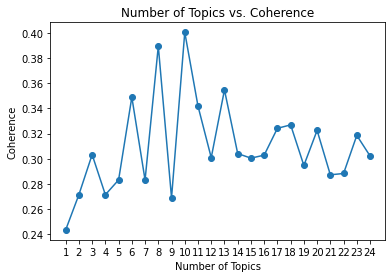

In [21]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

In [22]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=14, id2word = dictionary, passes=40,iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [23]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

topic_data =  pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)

## 4. Les éloges commencent par la naissance

In [24]:
new_df = df_cond.copy()
new_df = new_df[['Savant', 'Annee', 'Eloge', 'Side_Info', 'Eloge_lem']]

In [25]:
new_df['First_Sent'] = new_df['Eloge'].apply(lambda x : x.split('.')[0])
new_df

,Savant,Annee,Eloge,Side_Info,Eloge_lem,First_Sent
0,de la Chambre,1773,"Marin Cureau de la Chambre, médecin ordinaire ...",[],Marin cureau chambre médecin ordinaire roi naî...,"Marin Cureau de la Chambre, médecin ordinaire ..."
1,Frenicle,1773,"Nicolas Frenicle de Bessy, conseiller à la cou...",[],Nicolas Frenicle Bessy conseiller cour monnaie...,"Nicolas Frenicle de Bessy, conseiller à la cou..."
2,Picard,1773,L’abbé Picard naquit dans un temps où Kepler e...,[],abbé Picard naquit temps Kepler galiler venaie...,L’abbé Picard naquit dans un temps où Kepler e...
3,Mariotte,1773,"Edme Mariotte naquit à Dijon, ou du moins il y...",[],Edme mariotte naître dijon moins passa partie ...,"Edme Mariotte naquit à Dijon, ou du moins il y..."
4,Duclos,1773,"Samuel Cotreau Duclos, médecin ordinaire du ro...",[],Samuel Cotreau Duclos médecin ordinaire roi pr...,"Samuel Cotreau Duclos, médecin ordinaire du ro..."
...,...,...,...,...,...,...
61,Fougeroux,1789,"Auguste Denis Fougeroux, de l’Institut de Bolo...",[],Auguste Denis Fougeroux Institut Bologne socié...,"Auguste Denis Fougeroux, de l’Institut de Bolo..."
62,de Fourcroy,1791,"Charles-René de Fourcroy, maréchal de camp, gr...",[],Charles René Fourcroy maréchal camp grand croi...,"Charles-René de Fourcroy, maréchal de camp, gr..."
63,Turgot,1789,"Étienne-François Turgot, associé libre de l’Ac...",[],Étienne François Turgot associer libre académi...,"Étienne-François Turgot, associé libre de l’Ac..."
64,de L'Hôpital,1777,Chancelier de France. Discours présenté à L’ac...,[],Chancelier France discours présenter académie ...,Chancelier de France


In [26]:
ls = ['naquit','naitre', 'né']

def check_naissance(string):
    for word in ls:
        if word in string:
            return True
    return False

In [27]:
new_df['naissance'] = new_df['Eloge'].progress_apply(lambda x : check_naissance(x))

In [28]:
new_df[new_df['naissance']==False]

,Savant,Annee,Eloge,Side_Info,Eloge_lem,First_Sent,naissance
19,Bianchi,1773,"Il est mort en 1760, âgé de quatre-vingts ans,...",[],mort 1760 âgé quatre vingts an après avoir pro...,"Il est mort en 1760, âgé de quatre-vingts ans,...",False


In [29]:
new_df.loc[19, 'First_Sent']

'Il est mort en 1760, âgé de quatre-vingts ans, après avoir professé la médecine à Turin pendant quarante-cinq ans'

All the eulogies start with a statement on the birth

## 5. Synsets

In [30]:
#https://stackoverflow.com/questions/59198008/how-to-find-all-synoyms-for-a-french-word-using-nltk
#

from nltk.corpus import wordnet as wn
from nltk.wsd import lesk


In [31]:
list_pos = ['pleurer', 'malheur', 'martyr', 'tendresse', 'sensibilité', 'douceur touchante', 'reconnaissance', 'reconnoissance']
list_neg = ['ignorance', 'cupidité', 'égoïsme', 'bigoterie', 'frivolité', 'clanisme', 'envie', 'oisiveté', 'privilège', 'vanité']

new_df['list_pos'] = new_df['Eloge'].apply(lambda x : [i for i in list_pos if i in x])
new_df['list_neg'] = new_df['Eloge'].apply(lambda x : [i for i in list_neg if i in x])


In [32]:
set_pos = set()
set_neg = set()


        
for word in list_pos:
    set_pos.add(word)
    for ss in [n for synset in wn.synsets(word, lang = 'fra') for n in synset.lemma_names('fra')]:
        set_pos.add(ss)

for word in list_neg:
    set_neg.add(word)
    for ss in [n for synset in wn.synsets(word, lang = 'fra') for n in synset.lemma_names('fra')]:
        set_neg.add(ss)

In [33]:
set_pos.add('pleurs')
set_pos.add('pleure')

In [34]:
new_df.head(10)

,Savant,Annee,Eloge,Side_Info,Eloge_lem,First_Sent,naissance,list_pos,list_neg
0,de la Chambre,1773,"Marin Cureau de la Chambre, médecin ordinaire ...",[],Marin cureau chambre médecin ordinaire roi naî...,"Marin Cureau de la Chambre, médecin ordinaire ...",True,"[malheur, reconnaissance]","[envie, vanité]"
1,Frenicle,1773,"Nicolas Frenicle de Bessy, conseiller à la cou...",[],Nicolas Frenicle Bessy conseiller cour monnaie...,"Nicolas Frenicle de Bessy, conseiller à la cou...",True,[],[]
2,Picard,1773,L’abbé Picard naquit dans un temps où Kepler e...,[],abbé Picard naquit temps Kepler galiler venaie...,L’abbé Picard naquit dans un temps où Kepler e...,True,[reconnaissance],[]
3,Mariotte,1773,"Edme Mariotte naquit à Dijon, ou du moins il y...",[],Edme mariotte naître dijon moins passa partie ...,"Edme Mariotte naquit à Dijon, ou du moins il y...",True,"[malheur, reconnaissance]",[ignorance]
4,Duclos,1773,"Samuel Cotreau Duclos, médecin ordinaire du ro...",[],Samuel Cotreau Duclos médecin ordinaire roi pr...,"Samuel Cotreau Duclos, médecin ordinaire du ro...",True,[],[]
5,Blondel,1773,"François Blondel naquit à Ribemont, en Picardi...",[],François Blondel naître Ribemont Picardie 1617...,"François Blondel naquit à Ribemont, en Picardi...",True,[reconnaissance],"[ignorance, envie]"
6,Huygens,1773,"Christian Huygens naquit à la Haye, le 14 avri...",[],Christian Huygens naître Haye avril 1629 Const...,"Christian Huygens naquit à la Haye, le 14 avri...",True,[reconnaissance],[envie]
7,Charas,1773,"Moïse Charas naquit à Usez vers 1618, d’une fa...",[],Moïse Charas naître Usez vers 1618 famill prot...,"Moïse Charas naquit à Usez vers 1618, d’une fa...",True,[],"[ignorance, vanité]"
8,Roëmer,1773,Souvent l’observation d’un phénomène suffit po...,[],souvent observation phénomèn suffit rendre imm...,Souvent l’observation d’un phénomène suffit po...,True,"[malheur, reconnaissance]",[envie]
9,Rohaut,1773,"Au sortir du collège, où l’on n’enseignait enc...",[],sortir collège enseigner encore péripatétisme ...,"Au sortir du collège, où l’on n’enseignait enc...",True,[],[]


Text(0, 0.5, 'Number of eulogies appearing ing')

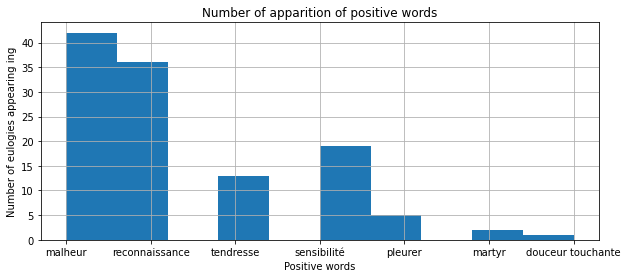

In [35]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from pandas import Series
new_df['list_pos'].apply(Series).stack().hist(figsize = (10, 4))
plt.title('Number of apparition of positive words')
plt.xlabel('Positive words')
plt.ylabel('Number of eulogies appearing ing')

Text(0, 0.5, 'Number of eulogies appearing ing')

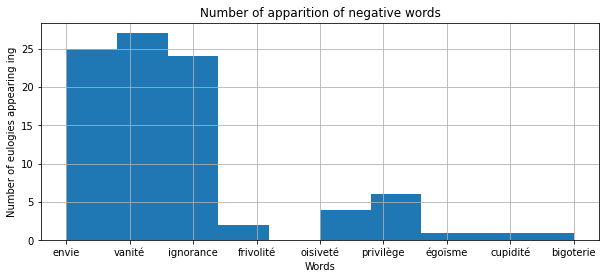

In [36]:

new_df['list_neg'].apply(Series).stack().hist(figsize = (10, 4))
plt.title('Number of apparition of negative words')
plt.xlabel('Words')
plt.ylabel('Number of eulogies appearing ing')

## 7. Part Of Speech

In [37]:
import pprint
import treetaggerwrapper

/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/treetaggerwrapper.py:739: FutureWarning: Possible nested set at position 8
  punct2find_re = re.compile("([^ ])([[" + ALONEMARKS + "])",
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/treetaggerwrapper.py:2043: FutureWarning: Possible nested set at position 152
  DnsHostMatch_re = re.compile("(" + DnsHost_expression + ")",
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/treetaggerwrapper.py:2067: FutureWarning: Possible nested set at position 409
  UrlMatch_re = re.compile(UrlMatch_expression, re.VERBOSE | re.IGNORECASE)
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/treetaggerwrapper.py:2079: FutureWarning: Possible nested set at position 192
  EmailMatch_re = re.compile(EmailMatch_expression, re.VERBOSE | re.IGNORECASE)


In [38]:
tagger = treetaggerwrapper.TreeTagger(TAGLANG='fr', TAGDIR = './../Treetagger')

In [39]:
tags = tagger.tag_text('Ceci est un test')
pprint.pprint(tags)

['Ceci\tPRO:DEM\tceci',
 'est\tVER:pres\têtre',
 'un\tDET:ART\tun',
 'test\tNOM\ttest']


In [40]:
df_cond['tags'] = df_cond['Eloge'].progress_apply(lambda x : tagger.tag_text(x))

In [41]:
df_cond['tags'] = df_cond['tags'].progress_apply(lambda x : treetaggerwrapper.make_tags(x))

In [42]:
df_cond.to_csv('./../../Data/Dataframes/df_cond_tags.csv', index = False)

In [43]:
df_cond['list_of_tags'] = df_cond['tags'].progress_apply(lambda x : [elem[1] for elem in x if len(elem)>2])


In [44]:
pos_tags = pd.read_csv('./../../Data/POS-tags.csv', header=None, index_col=0, squeeze=True).to_dict()
print(pos_tags)

{'ABR': 'abbreviation', 'ADJ': 'adjective', 'ADV': 'adverb', 'DET:ART': 'article', 'DET:POS': 'possessive pronoun (ma, ta, ...)', 'INT': 'interjection', 'KON': 'conjunction', 'NAM': 'proper name', 'NOM': 'noun', 'NUM': 'numeral', 'PRO': 'pronoun', 'PRO:DEM': 'demonstrative pronoun', 'PRO:IND': 'indefinite pronoun', 'PRO:PER': 'personal pronoun', 'PRO:POS': 'possessive pronoun (mien, tien, ...)', 'PRO:REL': 'relative pronoun', 'PRP': 'preposition', 'PRP:det': 'preposition plus article (au,du,aux,des)', 'PUN': 'punctuation', 'PUN:cit': 'punctuation citation', 'SENT': 'sentence tag', 'SYM': 'symbol', 'VER:cond': 'verb conditional', 'VER:futu': 'verb futur', 'VER:impe': 'verb imperative', 'VER:impf': 'verb imperfect', 'VER:infi': 'verb infinitive', 'VER:pper': 'verb past participle', 'VER:ppre': 'verb present participle', 'VER:pres': 'verb present', 'VER:simp': 'verb simple past', 'VER:subi': 'verb subjunctive imperfect', 'VER:subp': 'verb subjunctive present'}


In [45]:
df_cond['list_of_tags'] = df_cond['list_of_tags'].apply(lambda x : [pos_tags[elem] for elem in x])

Text(0, 0.5, "Nombre d'apparition")

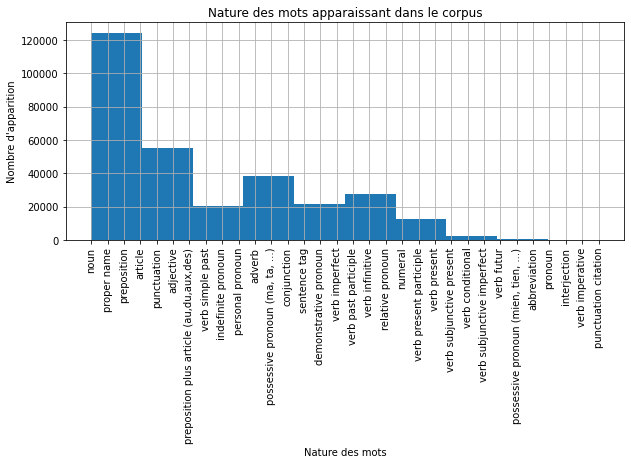

In [46]:
#plt.xticks(rotation='vertical')
df_cond['list_of_tags'].apply(Series).stack().hist(figsize = (10,4), xrot = 90)
plt.title('Nature des mots apparaissant dans le corpus')
plt.xlabel('Nature des mots')
plt.ylabel("Nombre d'apparition")

## 8. Negative Matrix Factorization

In [47]:
#https://predictivehacks.com/topic-modelling-with-nmf-in-python/

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

In [48]:
# use tfidf by removing tokens that don't appear in at least 50 documents
vect = TfidfVectorizer(min_df=50)
 
# Fit and transform
X = vect.fit_transform(df_cond.Eloge_lem)

In [49]:
# Create an NMF instance: model
# the 10 components will be the topics
model = NMF(n_components=10, random_state=5)
 
# Fit the model to TF-IDF
model.fit(X)
 
# Transform the TF-IDF: nmf_features
nmf_features = model.transform(X)

/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [50]:
# Create a DataFrame: components_df
components_df = pd.DataFrame(model.components_, columns=vect.get_feature_names())
components_df

,académie,alors,an,après,art,aucun,aussi,autre,avoir,bien,...,tout,travail,trop,trouver,très,utile,voir,vouloir,état,être
0,0.149311,0.056274,0.000000,0.050736,0.000000,0.024923,0.081087,0.373479,0.063557,0.071318,...,0.277485,0.077948,0.116647,0.067073,0.000000,0.033938,0.000000,0.000000,0.059883,0.198273
1,0.559812,0.012605,0.191481,0.009604,0.247346,0.000000,0.012119,0.000000,0.036112,0.009730,...,0.593179,0.000000,0.236454,0.000000,0.034640,0.253454,0.235026,0.000000,0.000000,0.018004
2,0.000000,0.222660,0.100077,0.019900,0.264063,0.000000,0.185783,0.000000,0.127756,0.000000,...,0.320023,0.000000,0.000000,0.111902,0.199700,0.194977,0.044323,0.237316,0.059059,0.395389
3,0.000000,0.006220,0.040089,0.000000,0.303707,0.073520,0.000000,0.000000,0.000000,0.319605,...,0.038164,0.000000,0.000000,0.142554,0.059026,0.006255,0.206193,0.000000,0.022300,0.154785
4,0.000000,0.067279,0.000000,0.091662,0.001694,0.091050,0.000000,0.095703,0.239688,0.153977,...,0.546107,0.000000,0.125689,0.000000,0.000000,0.067368,0.216429,0.199350,0.168335,0.282816
5,0.189961,0.000000,0.170222,0.000000,0.031753,0.008746,0.002625,0.022029,0.038858,0.133890,...,0.255659,0.160785,0.000000,0.000000,0.000000,0.010243,0.100286,0.001836,0.155076,0.159327
6,0.000000,0.043440,0.339360,0.177592,0.000000,0.000000,0.037187,0.000000,0.648389,0.000000,...,0.000000,0.000000,0.000000,0.025129,0.218965,0.224734,0.000000,0.208320,0.000000,0.184196
7,0.062983,0.053921,0.000000,0.182993,0.000000,0.058385,0.000000,0.100933,0.063009,0.092735,...,0.314951,0.026416,0.022479,0.128162,0.023264,0.025189,0.052315,0.000000,0.000000,0.026063
8,0.000000,0.067595,0.000000,0.000000,0.000000,0.100969,0.171103,0.250161,0.000000,0.133025,...,0.000000,0.031314,0.047432,0.080562,0.000000,0.000000,0.071508,0.069916,0.000000,0.311995
9,0.039541,0.066110,0.000000,0.091491,0.000000,0.068487,0.101307,0.000000,0.065426,0.000000,...,0.193615,0.513390,0.016614,0.000000,0.134766,0.011131,0.204119,0.028353,0.046410,0.000000


In [51]:
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
celui      0.882224
ce         0.598722
devoir     0.497374
autre      0.373479
comme      0.361561
premier    0.356558
pouvoir    0.342852
dont       0.325031
quelque    0.323349
tout       0.277485
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
tout           0.593179
académie       0.559812
observation    0.359213
lequel         0.289959
plusieurs      0.283346
grand          0.282702
nombre         0.279277
utile          0.253454
souvent        0.250899
art            0.247346
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
plus       1.105828
temps      0.427115
devoir     0.405589
être       0.395389
tout       0.320023
art        0.264063
faire      0.263527
vouloir    0.237316
rendre     0.233183
alors      0.222660
Name: 2, dtype: float64


For topic 4 the words with the highest value are:
faire          0.481279
plus           0.456719
comme          0.345915
observatio

## In 1773

In [52]:
warnings.simplefilter("ignore", DeprecationWarning)


# use tfidf by removing tokens that don't appear in at least 50 documents
vect = TfidfVectorizer()
 
df_1773 = df_cond[df_cond['Annee'] ==1773]
# Fit and transform
X = vect.fit_transform(df_1773.Eloge_lem)

# Create an NMF instance: model
# the 10 components will be the topics
model = NMF(n_components=4, random_state=5)
 
# Fit the model to TF-IDF
model.fit(X)
 
# Transform the TF-IDF: nmf_features
nmf_features = model.transform(X)

# Create a DataFrame: components_df
components_df = pd.DataFrame(model.components_, columns=vect.get_feature_names())

for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
plus        0.340598
ce          0.299278
celui       0.270765
pouvoir     0.268815
tout        0.241203
faire       0.221286
être        0.175872
autre       0.171288
dont        0.163505
principe    0.157749
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
professer      0.188089
quarante       0.170698
an             0.135202
ouvrage        0.128636
pratique       0.124412
quelquefois    0.120037
heureux        0.119343
avoir          0.116855
académie       0.115280
élève          0.114173
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
flamstead      0.210290
picard         0.183925
astronome      0.160622
ce             0.155626
plus           0.155599
observation    0.139924
fixe           0.121564
faire          0.114764
abbé           0.113931
étoile         0.110033
Name: 2, dtype: float64


For topic 4 the words with the highest value are:
rohaut            0.229462
boyle

/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


## In 1780

In [53]:
warnings.simplefilter("ignore", DeprecationWarning)


# use tfidf by removing tokens that don't appear in at least 50 documents
vect = TfidfVectorizer()
 
df_1773 = df_cond[df_cond['Annee'] ==1780]
# Fit and transform
X = vect.fit_transform(df_1773.Eloge_lem)

# Create an NMF instance: model
# the 10 components will be the topics
model = NMF(n_components=4, random_state=5)
 
# Fit the model to TF-IDF
model.fit(X)
 
# Transform the TF-IDF: nmf_features
nmf_features = model.transform(X)

# Create a DataFrame: components_df
components_df = pd.DataFrame(model.components_, columns=vect.get_feature_names())

for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
ce         2.734739
bucquet    2.508337
pouvoir    2.461464
celui      2.443920
plus       2.386440
devoir     2.250318
science    1.983797
tout       1.919581
être       1.702765
comme      1.438810
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
lieutaud    2.700480
plus        1.458275
pouvoir     1.415023
ce          1.400408
celui       1.216563
comme       1.202539
médecin     1.161982
tout        1.134171
faire       1.096474
être        0.970100
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
bucquet        0.481658
analyse        0.189744
substance      0.189744
cours          0.175148
végétal        0.161241
air            0.160553
devenir        0.158768
température    0.145408
tant           0.143665
loi            0.142536
Name: 2, dtype: float64


For topic 4 the words with the highest value are:
lieutaud    0.647390
ce          0.398045
comme       0.378113
celui    

/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


## In 1789

In [54]:
warnings.simplefilter("ignore", DeprecationWarning)


# use tfidf by removing tokens that don't appear in at least 50 documents
vect = TfidfVectorizer()
 
df_1789 = df_cond[df_cond['Annee'] ==1789]
# Fit and transform
X = vect.fit_transform(df_1773.Eloge_lem)

# Create an NMF instance: model
# the 10 components will be the topics
model = NMF(n_components=4, random_state=5)
 
# Fit the model to TF-IDF
model.fit(X)
 
# Transform the TF-IDF: nmf_features
nmf_features = model.transform(X)

# Create a DataFrame: components_df
components_df = pd.DataFrame(model.components_, columns=vect.get_feature_names())

for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
ce         2.734739
bucquet    2.508337
pouvoir    2.461464
celui      2.443920
plus       2.386440
devoir     2.250318
science    1.983797
tout       1.919581
être       1.702765
comme      1.438810
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
lieutaud    2.700480
plus        1.458275
pouvoir     1.415023
ce          1.400408
celui       1.216563
comme       1.202539
médecin     1.161982
tout        1.134171
faire       1.096474
être        0.970100
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
bucquet        0.481658
analyse        0.189744
substance      0.189744
cours          0.175148
végétal        0.161241
air            0.160553
devenir        0.158768
température    0.145408
tant           0.143665
loi            0.142536
Name: 2, dtype: float64


For topic 4 the words with the highest value are:
lieutaud    0.647390
ce          0.398045
comme       0.378113
celui    

/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


## 9. Most frequent words over time

In [55]:
#Most frequent words
# https://stackoverflow.com/questions/29903025/count-most-frequent-100-words-from-sentences-in-dataframe-pandas
from collections import Counter
Counter(" ".join(df_cond["Eloge_stem"]).split()).most_common(100)

[('homm', 1099),
 ('grand', 699),
 ('scienc', 669),
 ('don', 594),
 ('été', 594),
 ('fut', 538),
 ('part', 496),
 ('bien', 487),
 ('point', 483),
 ('fair', 482),
 ('ouvrag', 462),
 ('observ', 460),
 ('vérit', 446),
 ('util', 433),
 ('temp', 431),
 ('trouv', 401),
 ('forc', 371),
 ('sav', 362),
 ('form', 348),
 ('sent', 346),
 ('natur', 342),
 ('esprit', 342),
 ('vi', 333),
 ('academ', 332),
 ('objet', 328),
 ('plac', 319),
 ('méthod', 319),
 ('le', 305),
 ('occup', 305),
 ('trop', 299),
 ('médecin', 289),
 ('franc', 288),
 ('philosoph', 287),
 ('regard', 282),
 ('lois', 282),
 ('nouvel', 279),
 ('général', 279),
 ('princip', 277),
 ('eût', 275),
 ('mérit', 274),
 ('jam', 269),
 ('emploi', 267),
 ('gloir', 266),
 ('idé', 265),
 ('nombr', 257),
 ('état', 256),
 ('peupl', 251),
 ('presqu', 245),
 ('raison', 245),
 ('art', 244),
 ('naturel', 244),
 ('cherch', 241),
 ('découvert', 240),
 ('connaiss', 239),
 ('livr', 238),
 ('gen', 234),
 ('aucun', 234),
 ('moyen', 233),
 ('dev', 229),
 ('co

<AxesSubplot:xlabel='word'>

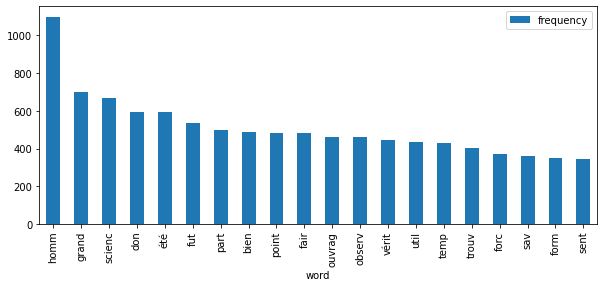

In [56]:
count_stem = Counter(" ".join(df_cond["Eloge_stem"]).split()).most_common(20)
df = pd.DataFrame(count_stem, columns=['word', 'frequency'])
df.plot(kind='bar', x='word', figsize = (10,4))

<AxesSubplot:xlabel='word'>

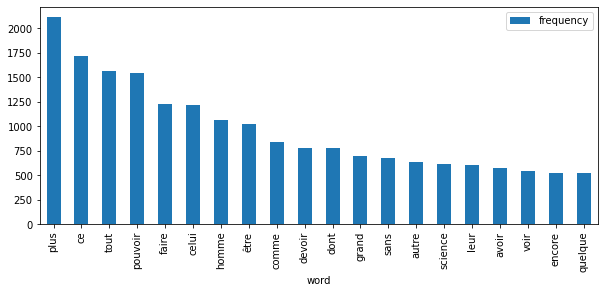

In [57]:
count_lem = Counter(" ".join(df_cond["Eloge_lem"]).split()).most_common(20)
df = pd.DataFrame(count_lem, columns=['word', 'frequency'])
df.plot(kind='bar', x='word', figsize = (10,4))

In [58]:
count_25 = Counter(" ".join(df_cond["Eloge_stem"]).split()).most_common(25)
most_25 = [elem[0] for elem in count_25]

In [59]:
most_25

['homm',
 'grand',
 'scienc',
 'don',
 'été',
 'fut',
 'part',
 'bien',
 'point',
 'fair',
 'ouvrag',
 'observ',
 'vérit',
 'util',
 'temp',
 'trouv',
 'forc',
 'sav',
 'form',
 'sent',
 'natur',
 'esprit',
 'vi',
 'academ',
 'objet']

In [60]:
most_25.pop(most_25.index('été'))
most_25.pop(most_25.index('fut'))


'fut'

In [61]:
def agg_func(ls, word = most_25):
    count = {}
    for w in word:
        count[w] = 0
    for st in ls :
        for w in word:
            count[w] += st.count(w)
    return count

group = df_cond.groupby('Annee').agg({'Eloge_stem' : agg_func, 'Auteur' : 'count'}).rename(columns ={'Eloge_stem' : 'Count_Words', 
                                                                                            'Auteur':'Count'}).reset_index()

In [62]:
group = pd.concat([group, group['Count_Words'].apply(pd.Series)], axis=1)
group.drop('Count_Words', axis=1, inplace = True)
group.drop('Count', axis=1, inplace = True)
pd.set_option('display.max_columns', 500)

Text(0, 0.5, 'Number of appearance')

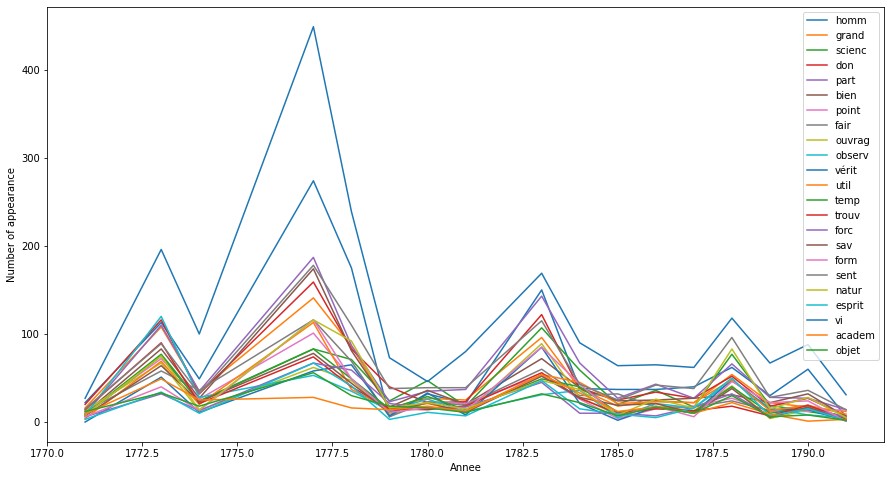

In [63]:
fig, ax = plt.subplots(figsize = (15,8))

for word in most_25:
    ax = group.plot(ax=ax, kind='line', x='Annee', y=word) 
plt.ylabel('Number of appearance')


In [64]:
def norm(dic, norm):
    for key, val in dic.items():
        dic[key] = val/norm
    return key

group_norm = df_cond.groupby('Annee').agg({'Eloge_stem' : agg_func, 'Auteur' : 'count'}).rename(columns ={'Eloge_stem' : 'Count_Words', 
                                                                                            'Auteur':'Count'}).reset_index()
group_norm['Count_words'] = group_norm.apply(lambda x : norm(x['Count_Words'], x['Count']) , axis = 1)


group_norm = pd.concat([group_norm, group_norm['Count_Words'].apply(pd.Series)], axis=1)
group_norm.drop('Count_Words', axis=1, inplace = True)
group_norm.drop('Count', axis=1, inplace = True)
pd.set_option('display.max_columns', 500)
group_norm

,Annee,Count_words,homm,grand,scienc,don,part,bien,point,fair,ouvrag,observ,vérit,util,temp,trouv,forc,sav,form,sent,natur,esprit,vi,academ,objet
0,1771,objet,22.000000,16.000000,9.000000,20.000000,9.000000,10.000000,10.000000,12.000000,13.000000,8.000000,0.000000,4.000000,8.000000,14.000000,6.000000,7.000000,6.000000,15.000000,8.000000,3.000000,27.000000,9.000000,12.00
1,1773,objet,4.520000,4.320000,3.080000,4.640000,4.400000,3.320000,2.880000,2.320000,2.680000,4.800000,2.040000,2.760000,3.000000,3.600000,1.280000,2.560000,1.600000,3.560000,3.000000,1.360000,7.840000,1.960000,1.32
2,1774,objet,49.000000,35.000000,24.000000,32.000000,35.000000,27.000000,26.000000,36.000000,13.000000,28.000000,11.000000,20.000000,23.000000,21.000000,13.000000,23.000000,13.000000,32.000000,14.000000,10.000000,100.000000,25.000000,18.00
3,1777,objet,54.800000,28.200000,16.600000,31.800000,37.400000,34.800000,20.200000,23.200000,12.400000,10.600000,11.600000,22.600000,16.600000,14.800000,13.400000,15.600000,23.200000,35.600000,23.200000,13.400000,89.800000,5.600000,11.20
4,1778,objet,58.333333,28.666667,23.666667,27.666667,29.000000,27.000000,16.333333,23.000000,15.666667,11.666667,21.666667,12.333333,16.333333,13.333333,19.666667,14.666667,16.333333,36.666667,30.666667,13.666667,79.666667,5.333333,10.00
5,1779,objet,3.000000,8.000000,12.000000,20.000000,11.500000,8.500000,6.000000,3.000000,4.500000,6.500000,3.500000,7.500000,7.500000,7.500000,10.500000,5.500000,5.500000,19.000000,8.000000,1.500000,36.500000,7.000000,9.00
6,1780,objet,16.000000,13.500000,23.500000,11.000000,17.500000,18.000000,11.500000,11.500000,11.000000,13.000000,16.500000,10.500000,14.500000,7.000000,8.000000,11.000000,8.000000,19.500000,11.000000,5.500000,23.000000,9.000000,8.00
7,1781,objet,10.500000,12.500000,9.000000,11.500000,18.500000,10.000000,10.500000,9.500000,5.000000,6.000000,4.000000,6.000000,7.000000,9.000000,8.500000,5.500000,6.500000,19.500000,7.500000,3.500000,40.000000,6.000000,5.50
8,1783,objet,30.000000,19.200000,21.400000,24.400000,28.600000,14.400000,10.600000,12.000000,17.800000,6.200000,17.000000,10.800000,9.800000,11.200000,9.000000,10.400000,17.000000,23.000000,9.400000,9.400000,33.800000,10.800000,6.40
9,1784,objet,7.600000,7.600000,11.800000,7.400000,13.400000,7.800000,5.200000,6.000000,5.600000,7.200000,4.200000,9.000000,8.000000,5.400000,2.000000,5.600000,8.600000,8.600000,7.400000,3.000000,18.000000,6.600000,4.40


Text(0, 0.5, 'Number of appearance normed by the number of eulogies this year')

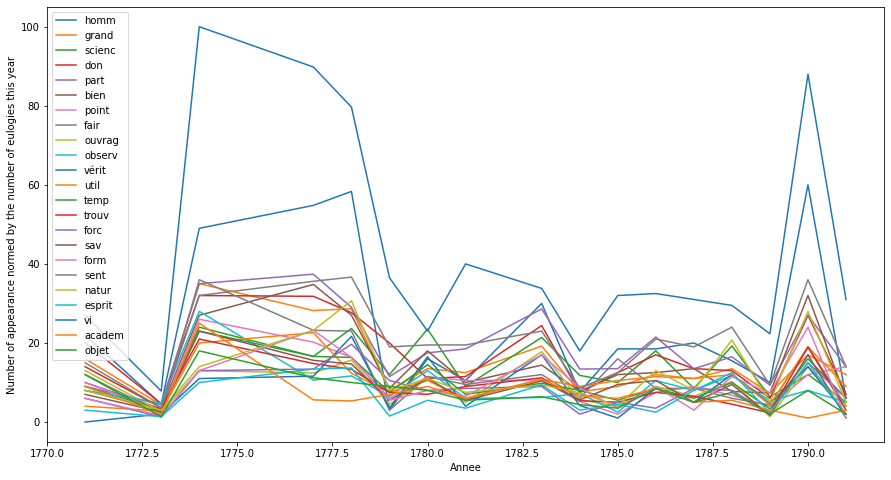

In [65]:
fig, ax = plt.subplots(figsize = (15,8))

for word in most_25:
    ax = group_norm.plot(ax=ax, kind='line', x='Annee', y=word) 
plt.ylabel('Number of appearance normed by the number of eulogies this year')

## 10. Bertopic

In [229]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer


/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [244]:
# Prepare embeddings
sentence_model = SentenceTransformer("distilbert-base-nli-mean-tokens")

docs = df_cond.Eloge_lem
embeddings = sentence_model.encode(docs, show_progress_bar=False)

# Create topic model
model = BERTopic(language ='French')
topics, probabilities = model.fit_transform(docs, embeddings)

/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# 11. Information Extraction

## a. République

In [107]:
df_cond['République'] = df_cond['Eloge'].progress_apply(lambda x : [sent for sent in x.split('.') 
                                                                    if (('République' in sent) or ('république' in sent) or ('republique' in sent))])

In [108]:
subdf = df_cond[df_cond.République.astype(bool)].copy()


In [111]:
for _, row in subdf.iterrows():
    for sent in row['République']:
        print(sent)

 Il avait été employé au conclave qui élut innocent X, et auprès de la république de Gènes    *************** <Essai d’une Histoire des correspondances de l'Académie royale des sciences>  Obligé, par reconnaissance et par devoir, de consacrer mon temps à l’Académie, je vais soumettre à son jugement quelques essais d’un travail qui, par son objet du moins, m’a paru n’être pas indigne de son attention : c’est une histoire de ses correspondants
 Pour établir une république d’Amazones et la perpétuer, il faudrait un système de législation si compliqué, que ce n’est pas chez des sauvages que l’on pourrait trouver un peuple de femmes
Albert de Haller, membre du conseil souverain de Berne, président de la société économique de la même ville, et de l’Académie de Gottingue, associé étranger de l’Académie des Sciences de Paris, et de presque toutes les autres sociétés savantes de l’Europe , naquit à Berne, le 18 octobre 1708, de Nicolas de Haller, avocat et chancelier du comté de Baden, d’une an

## b. Valeurs de la République des Sciences

In [127]:
val = ['vérité', 'raison', 'talent', 'transmission', 'savoir', 'osbservation', 'expérience','élite',
      'république', 'égalité', 'universelle', 'lumières', 'savant', 'œuvre', 'oeuvre', 'plan', 'réunion', 'commun', 'science',
      'progrès', 'ouvrage', 'république']
valeurs = []

for word in val :
    if not word.endswith('s'):
        valeurs.append(word+'s')
    valeurs.append(word.capitalize())
    valeurs.append((word+'s').capitalize())
    valeurs.append(word)
valeurs

['vérités',
 'Vérité',
 'Vérités',
 'vérité',
 'raisons',
 'Raison',
 'Raisons',
 'raison',
 'talents',
 'Talent',
 'Talents',
 'talent',
 'transmissions',
 'Transmission',
 'Transmissions',
 'transmission',
 'savoirs',
 'Savoir',
 'Savoirs',
 'savoir',
 'osbservations',
 'Osbservation',
 'Osbservations',
 'osbservation',
 'expériences',
 'Expérience',
 'Expériences',
 'expérience',
 'élites',
 'Élite',
 'Élites',
 'élite',
 'républiques',
 'République',
 'Républiques',
 'république',
 'égalités',
 'Égalité',
 'Égalités',
 'égalité',
 'universelles',
 'Universelle',
 'Universelles',
 'universelle',
 'Lumières',
 'Lumièress',
 'lumières',
 'savants',
 'Savant',
 'Savants',
 'savant',
 'œuvres',
 'Œuvre',
 'Œuvres',
 'œuvre',
 'oeuvres',
 'Oeuvre',
 'Oeuvres',
 'oeuvre',
 'plans',
 'Plan',
 'Plans',
 'plan',
 'réunions',
 'Réunion',
 'Réunions',
 'réunion',
 'communs',
 'Commun',
 'Communs',
 'commun',
 'sciences',
 'Science',
 'Sciences',
 'science',
 'Progrès',
 'Progrèss',
 'progrès',

In [128]:
df_cond['Valeurs'] = df_cond['Eloge'].progress_apply(lambda x : [sent for sent in x.split('.') if any(s in sent for s in valeurs)])    

In [179]:
df_val = df_cond[['Savant', 'Annee', 'Eloge', 'Valeurs']].copy()

In [180]:
import spacy
nlp = spacy.load("fr_core_news_sm")

df_val['Valeurs'] = df_val['Valeurs'].progress_apply(lambda x : ' '.join(x))
df_val['processed'] = df_val['Valeurs'].progress_apply(lambda x : re.sub(r'[^\w\s]', ' ', x))
df_val['processed'] = df_val['processed'].progress_apply(lambda x : ' '.join([w for w in x.split() if (w not in fr_stop and len(w)>2)]))
df_val['processed'] = df_val['processed'].progress_apply(lambda x : ' '.join([i for i in x.split(' ') if not i.isdigit()]))
df_val['processed'] = df_val['processed'].progress_apply(lambda x : ' '.join([token.lemma_ for token in nlp(x)]))



In [181]:
df_val.head()

,Savant,Annee,Eloge,Valeurs,processed
0,de la Chambre,1773,"Marin Cureau de la Chambre, médecin ordinaire ...",Il était bien éloigné de dédaigner les Scienc...,bien éloigner dédaigner science fortun espèce ...
1,Frenicle,1773,"Nicolas Frenicle de Bessy, conseiller à la cou...",On trouve un grand nombre de magistrats dans...,trouve grand nombre magistrat list savant âg i...
2,Picard,1773,L’abbé Picard naquit dans un temps où Kepler e...,Des théories plus vraies faisaient sentir ce ...,un théorie vraie sentir manquer partie pratiqu...
3,Mariotte,1773,"Edme Mariotte naquit à Dijon, ou du moins il y...",C’est de Dijon qu’il a daté plusieurs de ses ...,dijon dater ouvrage prouve nerf optique organ ...
4,Duclos,1773,"Samuel Cotreau Duclos, médecin ordinaire du ro...",Des hommes pleins de génie et d’idées chimér...,un homme plein génie idée chimérique cultivé c...


In [182]:
import gensim


final_reviews = df_val.processed.apply(lambda x : x.split())
dictionary = gensim.corpora.Dictionary(final_reviews)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_reviews]


In [183]:
coherence = []
for k in tqdm(range(1,25)):
    #print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,iterations=200, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_reviews,dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

100%|███████████████████████████████████████████| 24/24 [03:13<00:00,  8.08s/it]


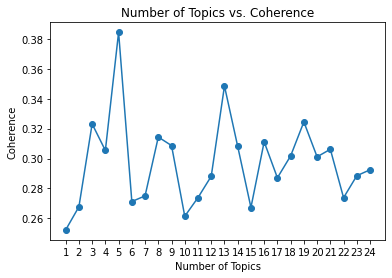

In [184]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

In [187]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=4, id2word = dictionary, passes=40,iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [188]:
pyLDAvis.enable_notebook()

topic_data =  pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary, mds = 'mmds')
pyLDAvis.display(topic_data)

In [190]:
ldamodel.show_topics()

[(0,
  '0.011*"science" + 0.008*"être" + 0.007*"homme" + 0.007*"ouvrage" + 0.006*"grand" + 0.006*"faire" + 0.005*"plante" + 0.004*"voir" + 0.004*"bien" + 0.004*"utile"'),
 (1,
  '0.011*"homme" + 0.007*"être" + 0.006*"peuple" + 0.006*"raison" + 0.005*"grand" + 0.005*"loi" + 0.005*"faire" + 0.005*"lumière" + 0.004*"voir" + 0.004*"nation"'),
 (2,
  '0.009*"être" + 0.008*"plante" + 0.008*"ouvrage" + 0.007*"science" + 0.006*"homme" + 0.006*"nature" + 0.005*"savant" + 0.005*"Jussieu" + 0.005*"voir" + 0.005*"grand"'),
 (3,
  '0.015*"science" + 0.010*"ouvrage" + 0.009*"homme" + 0.009*"être" + 0.006*"faire" + 0.006*"grand" + 0.005*"savant" + 0.004*"donner" + 0.004*"talent" + 0.004*"nouveau"')]

/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


# 12. Contingency, Self-Disclosure, Project-Back

## a. Self-disclosure

In [253]:
pronom_suj = [ "tu", "il", "elle", "on", "nous", "vous", "ils","elles"]
pronom_comp = [ "te", "le", "lui", "la", "les", "leur", "eux",  "toi"]
pronom_poss = ["le nôtre", "la nôtre", "les nôtres","le tien", "la tienne", "les tiens", 
               "les tiennes", "le vôtre", "la vôtre",  "les vôtres", "le sien", "la sienne", "les siens", "les siennes", "le leur", "la leur", 
               "les leurs"]
pronom_first = ['je', "j'","me","moi","le mien", "la mienne", "les miens", "les miennes"]

In [254]:
count = {}
all_pro = pronom_first.copy()
all_pro.extend(pronom_suj)
all_pro.extend(pronom_comp)
all_pro.extend(pronom_poss)
for pf in all_pro :
    count[pf] = df_cond.Eloge.str.count(pf).sum()


count_plot = dict((k, count[k]) for k in count.keys() if count[k]>0)

In [255]:
count_plot = dict(sorted(count_plot.items(), key=lambda item: item[1]))

<BarContainer object of 28 artists>

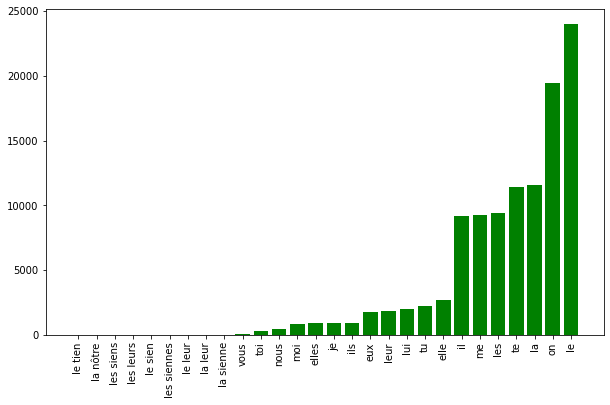

In [256]:
plt.figure(figsize =(10,6))
plt.xticks(rotation=90)
plt.bar(count_plot.keys(), count_plot.values(), color='g')


In [257]:
count_pf = sum([count_plot[k] for k in count_plot.keys() if k in pronom_first])
count_op = sum([count_plot[k] for k in count_plot.keys() if k not in pronom_first])

In [258]:
print('Percentage of first-person pronouns : ' + str((100*count_pf)/(count_pf+count_op)) + '%')

Percentage of first-person pronouns : 10.123844377720788%


## b. Contingency

## c. Project-Back

In [228]:
past = ['VER:subi', 'VER:simp', 'VER:pper', 'VER:impf']

not_pas = ['VER:subp', 'VER:pres','VER:ppre','VER:infi','VER:impe','VER:futu','VER:cond']



In [230]:
df_cond['verb'] = df_cond['tags'].apply(lambda x : [elem for elem in x if (len(elem)>1 and elem[1].startswith('VER'))])


In [ ]:
def count_tense(ls, past = past, not_past = not_pas):
    count = {'past':0, 'else':0}
    for elem in ls:
        if elem[1] in past:
            count['past'] += 1
        else :
            count['else'] +=1
            
    return count

In [234]:
df_cond['verb_past'] = df_cond['verb'].apply(lambda x : sum([1 for elem in x if (len(elem)>1 and elem[1] in past)]))
df_cond['other_verb'] = df_cond['verb'].apply(lambda x : sum([1 for elem in x if (len(elem)>1 and elem[1] in not_pas)]))

In [235]:
print('Number of verbs in past tense : ' + str(df_cond['verb_past'].sum()))
print('Number of verbs not in past tense : ' + str(df_cond['other_verb'].sum()))

Number of verbs in past tense : 22911
Number of verbs not in past tense : 23767


In [236]:
print('Percentage of verbs in past tense : ' + str((100*df_cond['verb_past'].sum())/(df_cond['verb_past'].sum()+df_cond['other_verb'].sum())) + '%')

Percentage of verbs in past tense : 49.083079823471444%


## Octis

https://github.com/MIND-Lab/OCTIS